In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import torch
import random
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from torch import nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text


import requests
url = 'https://sherlock-holm.es/stories/plain-text/advs.txt'
response = requests.get(url)
if response.status_code == 200:
    text = response.text
    preprocessed_text = preprocess(text)
    print(preprocessed_text[:500])
else:
    print("ERROR")

adventure sherlock holmes arthur conan doyle table content scandal bohemia redheaded league case identity boscombe valley mystery five orange pip man twisted lip adventure blue carbuncle adventure speckled band adventure engineer thumb adventure noble bachelor adventure beryl coronet adventure copper beech scandal bohemia table content chapter 1 chapter 2 chapter 3 chapter sherlock holmes always woman seldom heard mention name eye eclipse predominates whole sex felt emotion akin love irene adler


In [3]:
words = preprocessed_text.split()

VOCAB_SIZE = len(set(words))
word_counts = Counter(words)
most_common_words = word_counts.most_common(VOCAB_SIZE)
word2idx = {word: idx for idx, (word, _) in enumerate(most_common_words)}
idx2word = {idx: word for word, idx in word2idx.items()}

WINDOW_SIZE = 5
EMBEDDING_DIM = 100
BATCH_SIZE = 128
NEGATIVE_SAMPLES = 4

data = []
for i, word in enumerate(words):
    idx = word2idx.get(word, None)
    if idx is None:
        continue
    for j in range(max(i - WINDOW_SIZE, 0), min(i + WINDOW_SIZE + 1, len(words))):
        if i != j:
            context_word = words[j]
            context_idx = word2idx.get(context_word, None)
            if context_idx is not None:
                data.append((idx, context_idx))

class NegativeSamplingDataset(Dataset):
    def __init__(self, data, word_counts, negative_samples):
        self.data = data
        self.negative_samples = negative_samples
        self.weights = torch.FloatTensor(list(word_counts.values())) ** 0.75
        self.weights = self.weights / self.weights.sum()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        target, context = self.data[idx]
        negative_samples = torch.multinomial(self.weights, self.negative_samples * 10).tolist()
        negatives = [neg for neg in negative_samples if neg != context][:self.negative_samples]
        return target, context, negatives

dataset = NegativeSamplingDataset(data, word_counts, NEGATIVE_SAMPLES)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

class SkipGramNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim, negative_samples):
        super(SkipGramNegativeSampling, self).__init__()
        self.input_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.negative_samples = negative_samples

    def forward(self, target_words, context_words, negative_words):
        target_embed = self.input_embeddings(target_words)
        context_embed = self.output_embeddings(context_words)
        negative_embed = self.output_embeddings(negative_words)
        positive_scores = torch.mul(target_embed, context_embed).sum(dim=1)
        target_embed = target_embed.unsqueeze(2)
        negative_embed = negative_embed.view(-1, self.negative_samples, EMBEDDING_DIM)
        negative_scores = torch.bmm(negative_embed, target_embed).squeeze()
        positive_loss = torch.nn.functional.logsigmoid(positive_scores)
        negative_loss = torch.nn.functional.logsigmoid(-negative_scores).sum(dim=1)
        return -(positive_loss + negative_loss).mean()

model = SkipGramNegativeSampling(VOCAB_SIZE, EMBEDDING_DIM, NEGATIVE_SAMPLES)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

EPOCHS = 10
for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch_idx, (target, context, negatives) in enumerate(dataloader):
        target = torch.LongTensor(target)
        context = torch.LongTensor(context)
        negatives = torch.LongTensor(np.array(negatives))

        optimizer.zero_grad()
        loss = model(target, context, negatives)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss/len(dataloader)}")

input_vectors = model.input_embeddings.weight.data.cpu().numpy()
output_vectors = model.output_embeddings.weight.data.cpu().numpy()
word_vectors = (input_vectors + output_vectors) / 2

Epoch 1/10, Loss: 10.948303763620235
Epoch 2/10, Loss: 3.516292194247866
Epoch 3/10, Loss: 2.2914876230969163
Epoch 4/10, Loss: 1.8361357927191784
Epoch 5/10, Loss: 1.6044973532685316
Epoch 6/10, Loss: 1.4610660599212522
Epoch 7/10, Loss: 1.365205504932785
Epoch 8/10, Loss: 1.299692325708279
Epoch 9/10, Loss: 1.2533889290438192
Epoch 10/10, Loss: 1.221470592822548


In [4]:
word_vectors = torch.tensor(word_vectors).float()
required_words = ['king', 'man', 'woman', 'queen']
if not all(word in word2idx for word in required_words):
    raise ValueError("Required words not all in the vocabulary!")

def normalize_embeddings(embeddings):
    norms = torch.norm(embeddings, p=2, dim=1, keepdim=True)
    return embeddings / norms

normalized_vectors = normalize_embeddings(word_vectors)

king_idx = word2idx['king']
man_idx = word2idx['man']
woman_idx = word2idx['woman']
queen_idx = word2idx['queen']

king_vec = normalized_vectors[king_idx]
man_vec = normalized_vectors[man_idx]
woman_vec = normalized_vectors[woman_idx]
queen_vec = normalized_vectors[queen_idx]

approximate_queen_vec = king_vec - man_vec + woman_vec
cosine_similarity = torch.nn.functional.cosine_similarity(approximate_queen_vec.unsqueeze(0), queen_vec.unsqueeze(0))
print(f"Cosine similarity between 'queen' and 'king - man + woman': {cosine_similarity.item()}")

Cosine similarity between 'queen' and 'king - man + woman': 0.23352956771850586


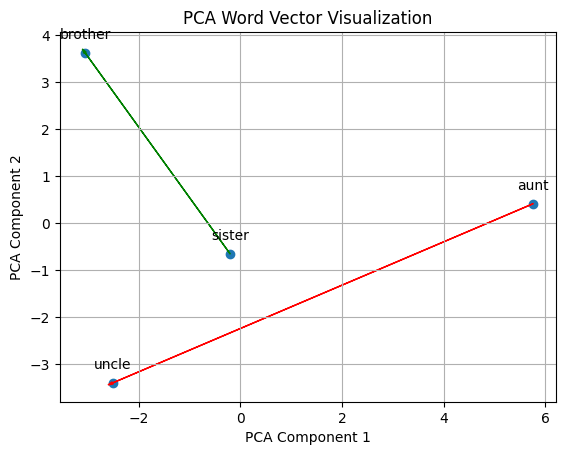

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

required_words = ['brother', 'sister', 'uncle', 'aunt']
if not all(word in word2idx for word in required_words):
    raise ValueError("Required words not all in the vocabulary!")

indices = [word2idx[word] for word in required_words]

selected_word_vectors = word_vectors[indices]

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(selected_word_vectors)
word_to_pca_vec = {word: reduced_vectors[i] for i, word in enumerate(required_words)}
diff_vector_brother_sister = word_to_pca_vec['brother'] - word_to_pca_vec['sister']
diff_vector_uncle_aunt = word_to_pca_vec['uncle'] - word_to_pca_vec['aunt']
plt.figure()
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])

for word, (x, y) in word_to_pca_vec.items():
    plt.annotate(word, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.arrow(word_to_pca_vec['sister'][0], word_to_pca_vec['sister'][1], diff_vector_brother_sister[0], diff_vector_brother_sister[1], head_width=0.05, head_length=0.1, fc='green', ec='green')
plt.arrow(word_to_pca_vec['aunt'][0], word_to_pca_vec['aunt'][1], diff_vector_uncle_aunt[0], diff_vector_uncle_aunt[1], head_width=0.05, head_length=0.1, fc='red', ec='red')

plt.title("PCA Word Vector Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()